### Kaggle Link
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

### Sentiment Analysis on Movie Reviews
---

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

The sentiment labels are:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df_train = pd.read_csv('../Data/Kaggle/sentiment-train.tsv', sep='\t', header=0)
df_valid = pd.read_csv('../Data/Kaggle/sentiment-test.tsv',  sep='\t', header=0)

In [3]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


### First Look at the Data

In [4]:
s = df_train['Sentiment'].value_counts()
s

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

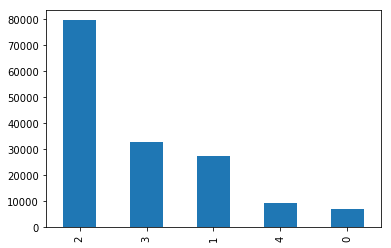

In [5]:
s.plot(kind='bar')

In [6]:
print('Negative:', s[0] + s[1])

Negative: 34345


In [7]:
print('Positive:', s[3] + s[4])

Positive: 42133


In [8]:
num_labels = len(df_train['Sentiment'].unique())

### More Pre-Processing

Before training any model, let's do more data pre-processing. Specifically, I'm goint to:

* Remove stop words
* Put all phrases in lower case
* Stem words

*PS: found that most of the code below can be done at once with [Keras](https://keras.io/preprocessing/text/) Tokenizer*

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

In [10]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}', '='])
stemmer = SnowballStemmer('english')

In [11]:
processed_docs_train = []
for df in [df_train, df_valid]:
    df['Parsed'] = df['Phrase'].apply(lambda x: x.lower())
    df['Parsed'] = df['Phrase'].apply(lambda x: word_tokenize(x))
    df['Parsed'] = df['Phrase'].apply(lambda x: [word for word in str(x).split() if word not in stop_words])
    df['Parsed'] = df['Parsed'].apply(lambda x: [stemmer.stem(word) for word in x])

In [12]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Parsed
0,1,1,A series of escapades demonstrating the adage ...,1,"[a, seri, escapad, demonstr, adag, good, goos,..."
1,2,1,A series of escapades demonstrating the adage ...,2,"[a, seri, escapad, demonstr, adag, good, goos]"
2,3,1,A series,2,"[a, seri]"
3,4,1,A,2,[a]
4,5,1,series,2,[seri]


In [13]:
df_valid.head()

,PhraseId,SentenceId,Phrase,Parsed
0,156061,8545,An intermittently pleasing but mostly routine ...,"[an, intermitt, pleas, most, routin, effort]"
1,156062,8545,An intermittently pleasing but mostly routine ...,"[an, intermitt, pleas, most, routin, effort]"
2,156063,8545,An,[an]
3,156064,8545,intermittently pleasing but mostly routine effort,"[intermitt, pleas, most, routin, effort]"
4,156065,8545,intermittently pleasing but mostly routine,"[intermitt, pleas, most, routin]"


Now, let's map each word to an ID...

In [14]:
from gensim import corpora

C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [15]:
dictionary = corpora.Dictionary(df_train['Parsed'].values)

In [16]:
print ('Dictionary size:', len(dictionary)) 

Dictionary size: 11842


In [17]:
len(set(np.concatenate(df_train['Parsed'].values, axis=0)))

11842

In [18]:
# We have to skip words found in test but not in training data
diff = set(np.concatenate(df_valid['Parsed'].values, axis=0)) - set(np.concatenate(df_train['Parsed'].values, axis=0))

In [19]:
for df in [df_train, df_valid]:
    df['Dict'] = df['Parsed'].apply(lambda x: [dictionary.token2id[word] for word in x if word not in diff])

In [20]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Parsed,Dict
0,1,1,A series of escapades demonstrating the adage ...,1,"[a, seri, escapad, demonstr, adag, good, goos,...","[0, 1, 2, 3, 4, 5, 6, 7, 5, 8, 9, 10, 11, 12, ..."
1,2,1,A series of escapades demonstrating the adage ...,2,"[a, seri, escapad, demonstr, adag, good, goos]","[0, 1, 2, 3, 4, 5, 6]"
2,3,1,A series,2,"[a, seri]","[0, 1]"
3,4,1,A,2,[a],[0]
4,5,1,series,2,[seri],[1]


In [21]:
df_valid.head()

,PhraseId,SentenceId,Phrase,Parsed,Dict
0,156061,8545,An intermittently pleasing but mostly routine ...,"[an, intermitt, pleas, most, routin, effort]","[575, 5848, 765, 908, 1343, 971]"
1,156062,8545,An intermittently pleasing but mostly routine ...,"[an, intermitt, pleas, most, routin, effort]","[575, 5848, 765, 908, 1343, 971]"
2,156063,8545,An,[an],[575]
3,156064,8545,intermittently pleasing but mostly routine effort,"[intermitt, pleas, most, routin, effort]","[5848, 765, 908, 1343, 971]"
4,156065,8545,intermittently pleasing but mostly routine,"[intermitt, pleas, most, routin]","[5848, 765, 908, 1343]"


### Count Vectorizer vs. Tfidf

In [22]:
X_train, X_valid, y_train = df_train['Phrase'], df_valid['Phrase'], df_train['Sentiment']

- **Count Vectorizer**

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(X_train)
print(len(vect.get_feature_names()))

X_train_vectorized = vect.transform(X_train)

15240


In [24]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['hawke' 'giddy' 'rare' 'giving' 'although' 'monumental' 'hilarious' 'damn'
 'engrossing' 'somewhat']

Largest Coefs: 
['disappointment' 'worst' 'garbage' 'failure' 'dud' 'worthless'
 'disgusting' 'unappealing' 'waste' 'unwatchable']


In [26]:
y_pred = model.predict(vect.transform(X_valid))

In [27]:
submission = pd.DataFrame({'PhraseId': df_valid['PhraseId'], 'Sentiment': y_pred})
submission.to_csv('sentiment-output.csv', index=False)

Kaggle Score: 0.60672

- **Tfidf**

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df=5).fit(X_train)
print(len(vect.get_feature_names()))

X_train_vectorized = vect.transform(X_train)

14609


In [29]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['luv' 'cor' 'blimey' 'blueblood' 'redneck' 'dooper' 'adorability'
 'synching' 'yuppie' 'somethings']

Largest tfidf: 
['zzzzzzzzz' 'fizzle' 'finished' 'finish' 'fingers' 'fingering' 'fingered'
 'finger' 'finest' 'finesse']


In [31]:
y_pred = model.predict(vect.transform(X_valid))

In [32]:
submission = pd.DataFrame({'PhraseId': df_valid['PhraseId'], 'Sentiment': y_pred})
submission.to_csv('sentiment-output.csv', index=False)

Let's check the following test:

In [33]:
print(model.predict(vect.transform(['a bad movie, considering the special effects',
                                    'not a bad movie, considering the special effects'])))

[2 2]


These reviews are treated the incorrectly classified by our current model. Since we are dealing with 1-grams, the models is not considering any sort of collocations in order to differentiate between the two examples above. So, let's try using ngrams.

In [34]:
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df=5, ngram_range=(1, 2)).fit(X_train)

print(len(vect.get_feature_names()))

X_train_vectorized = vect.transform(X_train)

75083


In [35]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['000' 'prickly indie' 'prickly' 'priceless' 'price to' 'price of'
 'price for' 'pride' 'price and' 'prey to']

Largest tfidf: 
['the' 'and' 'good' 'is' 'your' 'of' 'to' 'as' 'for' 'no']


In [37]:
y_pred = model.predict(vect.transform(X_valid))

In [38]:
submission = pd.DataFrame({'PhraseId': df_valid['PhraseId'], 'Sentiment': y_pred})
submission.to_csv('sentiment-output.csv', index=False)

These reviews are now correctly identified.

In [39]:
print(model.predict(vect.transform(['a bad movie, considering the special effects',
                                    'not a bad movie, considering the special effects'])))

[0 2]


Now we can notice that the examples are correctly classified.

### Model

#### Naive Bayes Classification

In [40]:
import nltk.classify.util

from nltk.classify import NaiveBayesClassifier

In [41]:
def word_feats(words):
    return dict([(word, True) for word in words])

In [42]:
def evaluate_classifier(featx):
    features = [(featx(row['Parsed']), row['Sentiment']) for index, row in df_train.iterrows()]

    cutoff = int(len(features)*3/4)
    trainfeats = features[:cutoff]
    validfeats = features[cutoff:]
    classifier = NaiveBayesClassifier.train(trainfeats)

    print('Accuracy:', nltk.classify.util.accuracy(classifier, validfeats))

    classifier.show_most_informative_features()
    
    return classifier

In [43]:
classifier = evaluate_classifier(word_feats)

test   = [word_feats(row['Parsed']) for index, row in df_valid.iterrows()]
y_pred = [classifier.classify(t) for t in test]

Accuracy: 0.4217352300397283
Most Informative Features
                    crap = True                0 : 2      =    186.6 : 1.0
                  atroci = True                0 : 2      =    186.6 : 1.0
                unimagin = True                0 : 2      =    156.1 : 1.0
                88-minut = True                0 : 2      =    133.3 : 1.0
                  stupid = True                0 : 3      =    131.5 : 1.0
               indescrib = True                0 : 2      =    118.0 : 1.0
                    poor = True                0 : 3      =    117.9 : 1.0
                   dazzl = True                4 : 2      =    113.0 : 1.0
                  polish = True                4 : 2      =    109.6 : 1.0
                  redund = True                0 : 2      =    107.4 : 1.0


In [44]:
submission = pd.DataFrame({'PhraseId': df_valid['PhraseId'], 'Sentiment': y_pred})
submission.to_csv('sentiment-output.csv', index=False)

Again, not a good result. Let's try to use ngrams here too.

In [45]:
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
 
def bigram_word_feats(words, score_fn=BigramAssocMeasures.raw_freq, n=200):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    return dict([(ngram, True) for ngram in itertools.chain(words, bigrams)])

In [46]:
classifier = evaluate_classifier(bigram_word_feats)
    
test   = [word_feats(row['Parsed']) for index, row in df_valid.iterrows()]
y_pred = [classifier.classify(t) for t in test]

Accuracy: 0.4015122388824811
Most Informative Features
                    crap = True                0 : 2      =    186.6 : 1.0
                  atroci = True                0 : 2      =    186.6 : 1.0
         ('one', 'year') = True                4 : 2      =    162.9 : 1.0
                unimagin = True                0 : 2      =    156.1 : 1.0
      ('beauti', 'film') = True                4 : 2      =    145.1 : 1.0
                88-minut = True                0 : 2      =    133.3 : 1.0
                  stupid = True                0 : 3      =    131.5 : 1.0
         ('one', 'best') = True                4 : 2      =    130.7 : 1.0
     ('vapid', 'devoid') = True                0 : 2      =    125.6 : 1.0
     ('inept', 'direct') = True                0 : 2      =    118.0 : 1.0


In [47]:
submission = pd.DataFrame({'PhraseId': df_valid['PhraseId'], 'Sentiment': y_pred})
submission.to_csv('sentiment-output.csv', index=False)

#### Long Short-Term Memory

Now let's get ready to use an LSTM model...

In [48]:
mean = df_train['Dict'].apply(lambda x: len(x)).mean()

In [49]:
std = df_train['Dict'].apply(lambda x: len(x)).std()

In [50]:
print('Phrase size mean and std: {0:.2f},'.format(mean), '{0:.2f}'.format(std))

Phrase size mean and std: 4.26, 3.85


In [51]:
seq_len = np.round(mean + 2*std).astype(int)

In [52]:
print('Seq len:', seq_len)

Seq len: 12


In [53]:
X_train = df_train.drop(['Sentiment'], axis=1)
y_train = df_train['Sentiment']
X_valid = df_valid

In [54]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

In [55]:
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, Conv1D, MaxPooling1D

In [56]:
X_train = sequence.pad_sequences(np.array(X_train['Dict']), maxlen=seq_len)
X_valid = sequence.pad_sequences(np.array(X_valid['Dict']), maxlen=seq_len)

In [57]:
y_train = to_categorical(y_train)

In [58]:
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(len(dictionary), embedding_vector_length, input_length=seq_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(num_labels, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

print(model.summary())

hist = model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_split=0.33)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 64)            757888    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 847,141
Trainable params: 847,141
Non-trainable params: 0
_________________________________________________________________
None
Train on 104560 samples, validate on 51500 samples
Epoch 1/5
153s - loss: 0.3467 - acc: 0.8493 - val_loss: 0.3518 - val_acc: 0.8417

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


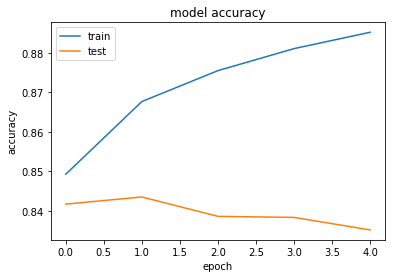

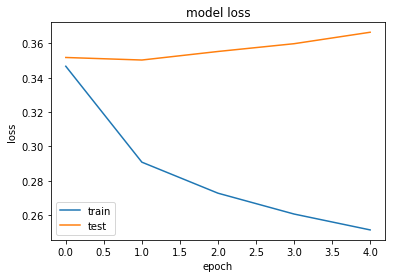

In [59]:
plot_history(hist)

In [60]:
y_pred = model.predict_classes(X_valid)

66292/66292 [==============================] - 13s    


In [ ]:
submission = pd.DataFrame({'PhraseId': df_valid['PhraseId'], 'Sentiment': y_pred})
submission.to_csv('sentiment-output.csv', index=False)

#### Convolutional Neural Networks

In [ ]:
from keras.layers import GlobalMaxPooling1D

model = Sequential()
model.add(Embedding(len(dictionary), embedding_vector_length, input_length=seq_len))
model.add(Dropout(0.2))
model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(num_labels))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

hist = model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_split=0.33)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 12, 64)            757888    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 250)           48250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
__________

In [ ]:
plot_history(hist)

In [ ]:
y_pred = model.predict_classes(X_valid)

In [ ]:
submission = pd.DataFrame({'PhraseId': df_valid['PhraseId'], 'Sentiment': y_pred})
submission.to_csv('sentiment-output.csv', index=False)